In [1]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [2]:
def svd(A):
    """
    Parameters
    ----------
    A: torch.FloatTensor
        A tensor of shape [b, m, n].
    
    Returns
    -------
    U: [b, m, n]
    S: [b, n, n]
    V: [b, n, n]
    
    References
    ----------
    1. https://www.youtube.com/watch?v=pSbafxDHdgE&t=205s
    2. https://www2.math.ethz.ch/education/bachelor/lectures/hs2014/other/linalg_INFK/svdneu.pdf
    """
    ATA = torch.matmul(A.transpose(-1, -2), A)
    lv, vv = torch.linalg.eig(ATA)
    lv = lv.real
    vv = vv.real
    V = F.normalize(vv, dim=1)
    S = torch.diag_embed(torch.sqrt(lv))
    U = torch.matmul(torch.matmul(A, V), torch.inverse(S))
    return U, S, V

In [3]:
A = torch.randn(1000, 4, 3)
U, S, V = svd(A)

In [4]:
A_ = torch.matmul(U, torch.matmul(S, V.transpose(-1, -2)))
torch.dist(A_, A)

tensor(2.7065e-05)

In [5]:
import torch.utils.data as torch_data
import torch.optim as optim

In [6]:
class SvdDataset(torch_data.Dataset):
    
    def __init__(self, num_samples=1000, m=512, n=10, k=2):
        self.num_samples = num_samples
        self.m = m
        self.n = n
        self.k = k
        
        self.A = torch.randn(num_samples, m, n)
        self.U, _, _ = svd(self.A)
    
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, index):
        input_ = self.A[index]
        output_ = self.U[index, :, :self.k]
        return {
            'input': input_, 
            'output': output_
        }

In [7]:
train_ds = SvdDataset(num_samples=1000)
test_ds = SvdDataset(num_samples=100)

In [8]:
batch_size = 128
train_dl = torch_data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, pin_memory=True, drop_last=True)
test_dl = torch_data.DataLoader(test_ds, batch_size=batch_size, shuffle=False, pin_memory=True, drop_last=False)

In [9]:
class DecompositionNet(nn.Module):
    
    def __init__(self, k, emb_dim, max_demix):
        super(DecompositionNet, self).__init__()
        self.k = k
        self.emb_dim = emb_dim
        self.max_demix = max_demix
        
        self.ff1 = nn.Linear(max_demix, max_demix)
        self.ff2 = nn.Linear(max_demix, k)
    
    def forward(self, x):
        # x: [batch, emb_dim, max_demix] -> [batch, emb_dim, k]
        x = self.ff1(x)
        x = self.ff2(torch.relu(x))
        return x

In [10]:
net = DecompositionNet(k=2, emb_dim=512, max_demix=10)
criterion = nn.MSELoss()
optimiser = optim.Adam(net.parameters(), lr=1e-4, betas=(0.95, 0.999))

In [11]:
net.to('cuda')
losses = []
for epoch in tqdm(range(100), leave=False):
    running_loss = 0.0
    for i, data in enumerate(train_dl, 0):
        inputs, labels = data['input'], data['output']
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        identities1 = torch.eye(2).reshape(1, 2, 2).repeat(batch_size, 1, 1).to('cuda')
        identities2 = torch.eye(512).reshape(1, 512, 512).repeat(batch_size, 1, 1).to('cuda')

        # zero the parameter gradients
        optimiser.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        outputs = F.normalize(outputs, p=2, dim=1)
        loss1 = criterion(outputs, labels)
        gs1 = torch.matmul(outputs.transpose(-1, -2), outputs)
        loss2 = criterion(gs1, identities1)
        gs2 = torch.matmul(outputs, outputs.transpose(-1, -2))
        loss3 = criterion(gs2, identities2)
        loss = loss1 + loss2 + loss3
        loss.backward()
        optimiser.step()

        # print statistics
        running_loss += loss.item()
    running_loss = running_loss / len(train_dl.dataset)
    losses.append(running_loss)
    # print(f'[{epoch+1}] loss: {running_loss:.6f}')

print('Finished Training')

  0%|          | 0/100 [00:00<?, ?it/s]

Finished Training


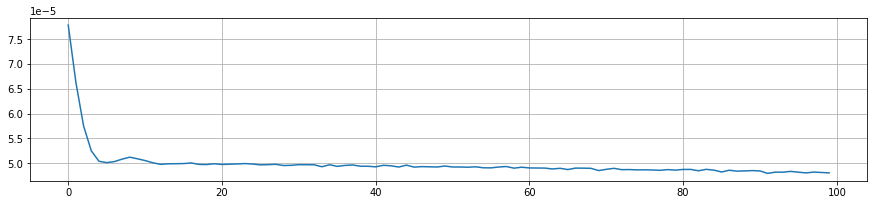

In [12]:
plt.figure(figsize=(15, 3))
plt.plot(losses)
plt.grid()
plt.show()

In [13]:
output_vectors = []
for i, data in enumerate(test_dl, 0):
    inputs, labels = data['input'], data['output']
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    outputs = net(inputs)
    outputs = F.normalize(outputs, p=2, dim=1)

print('Finished Testing')

Finished Testing


In [14]:
outputs.shape

torch.Size([100, 512, 2])

In [15]:
print(outputs[0])

tensor([[ 0.0522, -0.0337],
        [ 0.0121,  0.0337],
        [ 0.0035,  0.0327],
        ...,
        [-0.0035,  0.0471],
        [ 0.0119,  0.0300],
        [ 0.0910, -0.0034]], device='cuda:0', grad_fn=<SelectBackward0>)


In [16]:
print(labels[0])

tensor([[-0.0295,  0.0201],
        [ 0.0039,  0.0528],
        [ 0.0264, -0.0085],
        ...,
        [ 0.0332,  0.0193],
        [-0.0437,  0.0018],
        [-0.0078, -0.0031]], device='cuda:0')


In [17]:
torch.dot(outputs[0][:, 0], outputs[0][:, 1])

tensor(-0.0223, device='cuda:0', grad_fn=<DotBackward0>)

In [18]:
torch.dot(labels[0][:, 0], labels[0][:, 1])

tensor(1.4715e-07, device='cuda:0')

In [19]:
torch.dist(torch.matmul(outputs.transpose(-1, -2), outputs), torch.eye(2).reshape(1, 2, 2).repeat(100, 1, 1).to('cuda'))

tensor(0.7473, device='cuda:0', grad_fn=<DistBackward0>)

In [20]:
torch.dist(torch.matmul(labels.transpose(-1, -2), labels), torch.eye(2).reshape(1, 2, 2).repeat(100, 1, 1).to('cuda'))

tensor(1.8751e-05, device='cuda:0')